In [1]:
### Github: CollegeSeniorUser, machine_learning_project, Project5 

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#### 1(b) Build a decision tree on the whole data set and plot it
- 1st decision node is Nephritis
- 2nd decision node is Inflammation Bladder
- 3rd decision node is combined 

In [4]:
df = pd.read_csv('../data/diagnosis_data.csv', delimiter=',', decimal='.')
df.columns = ['Temperature', 'Nausea','Lumbar Pain', 'Urine Pushing',
              'Micturition Pains','Burning Urethra','Inflammation Bladder','Nephritis']
df.head()

Temperature Nausea Lumbar Pain Urine Pushing Micturition Pains  \
0         35.9     no          no           yes               yes   
1         35.9     no         yes            no                no   
2         36.0     no          no           yes               yes   
3         36.0     no         yes            no                no   
4         36.0     no         yes            no                no   

  Burning Urethra Inflammation Bladder Nephritis  
0             yes                  yes        no  
1              no                   no        no  
2             yes                  yes        no  
3              no                   no        no  
4              no                   no        no

In [5]:
df = df.replace({'yes': 1, 'no': 0})
df.head()

Temperature  Nausea  Lumbar Pain  Urine Pushing  Micturition Pains  \
0         35.9       0            0              1                  1   
1         35.9       0            1              0                  0   
2         36.0       0            0              1                  1   
3         36.0       0            1              0                  0   
4         36.0       0            1              0                  0   

   Burning Urethra  Inflammation Bladder  Nephritis  
0                1                     1          0  
1                0                     0          0  
2                1                     1          0  
3                0                     0          0  
4                0                     0          0

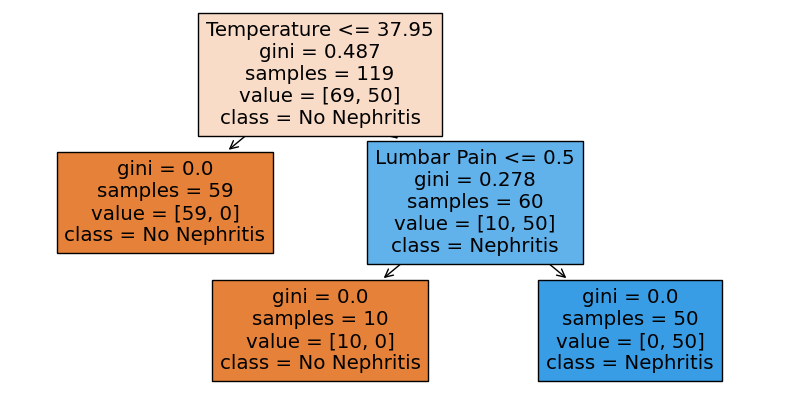

In [6]:
# Nephritis
x_nephritis = df.drop(columns=['Nephritis'])
y_nephritis = df['Nephritis']

tree_model_nephritis = DecisionTreeClassifier(random_state=0)
tree_model_nephritis.fit(x_nephritis, y_nephritis)

plt.figure(figsize=(10, 5))
plot_tree(tree_model_nephritis, feature_names=x_nephritis.columns.tolist(), class_names=['No Nephritis', 'Nephritis'], filled=True)
plt.show()

In [7]:
def tree_to_rules(tree, feature_names, response):
    tree_ = tree.tree_
    feature_name =[]
    rules = []
    
    for i in tree_.feature:
        if i != _tree.TREE_UNDEFINED:
            feature_name.append(feature_names[i])
        else:
            feature_name.append("undefined!")
            
    
    def recurse(node, depth, rule="If "):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            rule_left = f"{rule}{name} <= {threshold:.2f} Then "
            rule_right = f"{rule}{name} > {threshold:.2f} Then "
            recurse(tree_.children_left[node], depth + 1, rule_left)
            recurse(tree_.children_right[node], depth + 1, rule_right)
        else:
            value = tree_.value[node]
            decision = f"{response} True" if value[0][1] > value[0][0] else f"{response} False"
            rules.append(f"{rule}Decision: {decision}")
    
    recurse(0, 1)
    return rules

rules = tree_to_rules(tree_model_nephritis, x_nephritis.columns.tolist(),'nephritis')
rules[:] 


['If Temperature <= 37.95 Then Decision: nephritis False',
 'If Temperature > 37.95 Then Lumbar Pain <= 0.50 Then Decision: nephritis False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Decision: nephritis True']

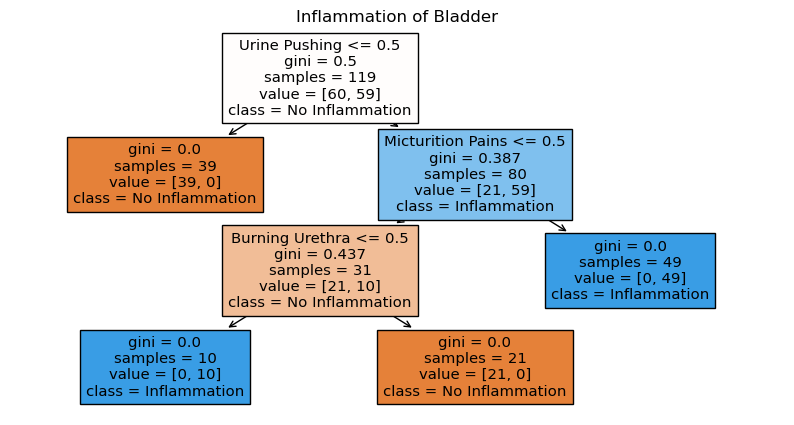

['If Urine Pushing <= 0.50 Then Decision: inflammation bladder False',
 'If Urine Pushing > 0.50 Then Micturition Pains <= 0.50 Then Burning Urethra <= 0.50 Then Decision: inflammation bladder True',
 'If Urine Pushing > 0.50 Then Micturition Pains <= 0.50 Then Burning Urethra > 0.50 Then Decision: inflammation bladder False',
 'If Urine Pushing > 0.50 Then Micturition Pains > 0.50 Then Decision: inflammation bladder True']

In [8]:
#inflammation bladder
x_bladder = df.drop(columns=['Inflammation Bladder'])
y_bladder = df['Inflammation Bladder']

tree_model_bladder = DecisionTreeClassifier(random_state=0)
tree_model_bladder.fit(x_bladder, y_bladder)

plt.figure(figsize=(10, 5))
plot_tree(tree_model_bladder, feature_names=x_bladder.columns.tolist(), class_names=['No Inflammation', 'Inflammation'], filled=True)
plt.title("Inflammation of Bladder")
plt.show()

rules_bladder = tree_to_rules(tree_model_bladder, x_bladder.columns.tolist(), 'inflammation bladder')
rules_bladder[:]

In [9]:
rules = tree_to_rules(tree_model_bladder, x_bladder.columns.tolist(),'bladder inflammation')
rules[:] 

['If Urine Pushing <= 0.50 Then Decision: bladder inflammation False',
 'If Urine Pushing > 0.50 Then Micturition Pains <= 0.50 Then Burning Urethra <= 0.50 Then Decision: bladder inflammation True',
 'If Urine Pushing > 0.50 Then Micturition Pains <= 0.50 Then Burning Urethra > 0.50 Then Decision: bladder inflammation False',
 'If Urine Pushing > 0.50 Then Micturition Pains > 0.50 Then Decision: bladder inflammation True']

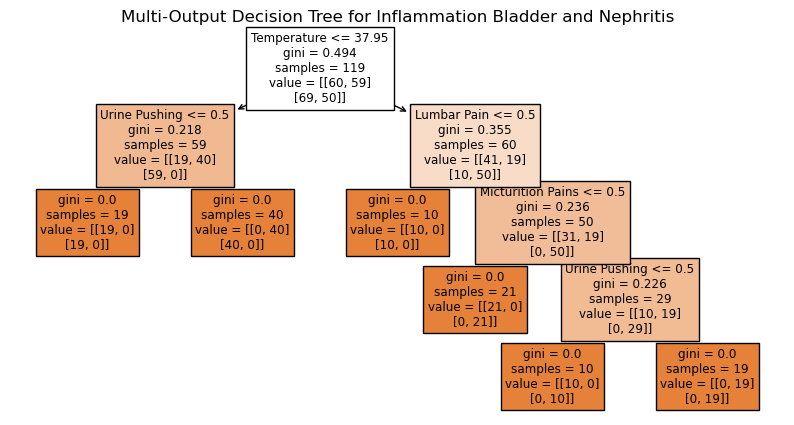

Rules for Multi-Output Decision Tree:


['If Temperature <= 37.95 Then Urine Pushing <= 0.50 Then Decision: combined False',
 'If Temperature <= 37.95 Then Urine Pushing > 0.50 Then Decision: combined True',
 'If Temperature > 37.95 Then Lumbar Pain <= 0.50 Then Decision: combined False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains <= 0.50 Then Decision: combined False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains > 0.50 Then Urine Pushing <= 0.50 Then Decision: combined False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains > 0.50 Then Urine Pushing > 0.50 Then Decision: combined True']

In [10]:
# combined two response variable 
x_combo = df.drop(columns=['Inflammation Bladder', 'Nephritis'])

y_combo = df[['Inflammation Bladder', 'Nephritis']]

tree_combo = DecisionTreeClassifier(random_state=0)
tree_combo.fit(x_combo, y_combo)

plt.figure(figsize=(10, 5))
plot_tree(
    tree_combo, 
    feature_names=x_combo.columns.tolist(), 
    class_names=[
        'No Inflammation, No Nephritis', 
        'Inflammation, No Nephritis', 
        'No Inflammation, Nephritis', 
        'Inflammation, Nephritis'
    ], 
    filled=True
)
plt.title("Multi-Output Decision Tree for Inflammation Bladder and Nephritis")
plt.show()

multi_output_rules = tree_to_rules(tree_combo, x_combo.columns.tolist(),'combined')
print("Rules for Multi-Output Decision Tree:")
multi_output_rules[:]

In [11]:
def tree_to_rules_combo(tree, feature_names, responses):
    tree_ = tree.tree_
    feature_name = []
    rules = []
    
    for i in tree_.feature:
        if i != _tree.TREE_UNDEFINED:
            feature_name.append(feature_names[i])
        else:
            feature_name.append("undefined!")
    
    def recurse(node, depth, rule="If "):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            rule_left = f"{rule}{name} <= {threshold:.2f} Then "
            rule_right = f"{rule}{name} > {threshold:.2f} Then "
            recurse(tree_.children_left[node], depth + 1, rule_left)
            recurse(tree_.children_right[node], depth + 1, rule_right)
        else:
            value = tree_.value[node]
            decisions = []
            for i, response in enumerate(responses):
                decision = f"{response}: True" if value[0][i] > value[0][(i + 1) % 2] else f"{response}: False"
                decisions.append(decision)
            rules.append(f"{rule}Decision: {', '.join(decisions)}")
    
    recurse(0, 1)
    return rules

rules = tree_to_rules_combo(tree_combo, x_combo.columns.tolist(), ['Inflammation Bladder', 'Nephritis'])
rules[:]


['If Temperature <= 37.95 Then Urine Pushing <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature <= 37.95 Then Urine Pushing > 0.50 Then Decision: Inflammation Bladder: False, Nephritis: True',
 'If Temperature > 37.95 Then Lumbar Pain <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains > 0.50 Then Urine Pushing <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Micturition Pains > 0.50 Then Urine Pushing > 0.50 Then Decision: Inflammation Bladder: False, Nephritis: True']

#### 1(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.
- 1st decision node is Nephritis
- 2nd decision node is Inflammation Bladder
- 3rd decision node is combined 

In [13]:
# Pruning nephritis
path = tree_model_nephritis.cost_complexity_pruning_path(x_nephritis, y_nephritis)
ccp_alphas = path.ccp_alphas

# fit trees
trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(x_nephritis, y_nephritis)
    trees.append(tree)

num_leaves = []
for tree in trees:
    num_leaves.append(tree.get_n_leaves())

results = list(zip(ccp_alphas,num_leaves))
results


[(0.0, 3), (0.1400560224089636, 2), (0.34719770261045596, 1)]

In [14]:
# use cv_scores to decide which ccp_alpha to use
cv_scores = []

for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    pruned_tree.fit(x_nephritis, y_nephritis)
    scores = cross_val_score(pruned_tree, x_nephritis, y_nephritis, cv=5)
    cv_scores.append(scores.mean())
    
results = list(zip(ccp_alphas,num_leaves,cv_scores))
results

[(0.0, 3, 0.8547101449275363),
 (0.1400560224089636, 2, 0.8547101449275363),
 (0.34719770261045596, 1, 0.5797101449275363)]

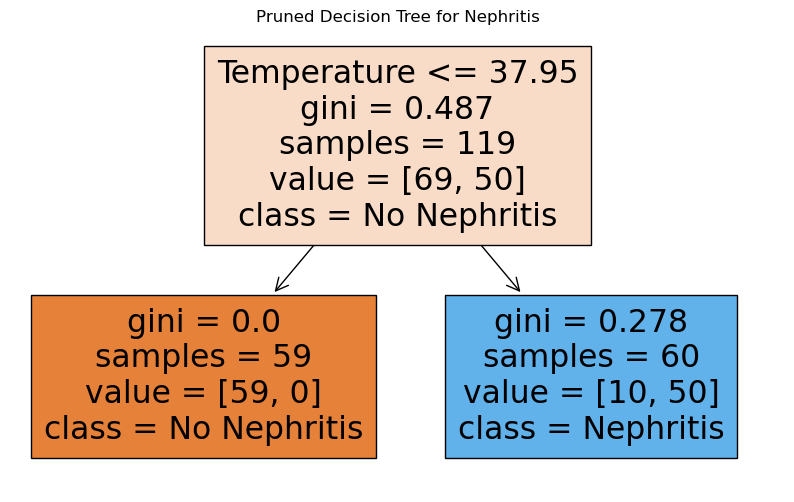

['If Temperature <= 37.95 Then Decision: nephritis False',
 'If Temperature > 37.95 Then Decision: nephritis True']

In [15]:
# choose (0.1400560224089636, 2) penlize the complex tree while maintain good accuracy
pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0.1400560224089636)
pruned_tree.fit(x_nephritis, y_nephritis)

plt.figure(figsize=(10, 6))
plot_tree(pruned_tree, feature_names=x_nephritis.columns.tolist(), class_names=['No Nephritis', 'Nephritis'], filled=True)
plt.title("Pruned Decision Tree for Nephritis")
plt.show()

pruned_rules = tree_to_rules(pruned_tree, x_nephritis.columns.tolist(), 'nephritis')
pruned_rules

In [16]:
# Pruning Inflammation Bladder
path = tree_model_bladder.cost_complexity_pruning_path(x_bladder, y_bladder)
ccp_alphas = path.ccp_alphas

# fit trees
trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(x_bladder, y_bladder)
    trees.append(tree)

num_leaves = []
for tree in trees:
    num_leaves.append(tree.get_n_leaves())

results = list(zip(ccp_alphas,num_leaves))
results

[(0.0, 4),
 (0.11385199240986717, 3),
 (0.1464421252371917, 2),
 (0.23967057411199771, 1)]

In [17]:
# use cv_scores to decide which ccp_alpha to use
cv_scores = []

for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    pruned_tree.fit(x_bladder, y_bladder)
    scores = cross_val_score(pruned_tree, x_bladder, y_bladder, cv=5)
    cv_scores.append(scores.mean())
    
results = list(zip(ccp_alphas,num_leaves,cv_scores))
results

[(0.0, 4, 1.0),
 (0.11385199240986717, 3, 0.8293478260869565),
 (0.1464421252371917, 2, 0.8144927536231885),
 (0.23967057411199771, 1, 0.6478260869565217)]

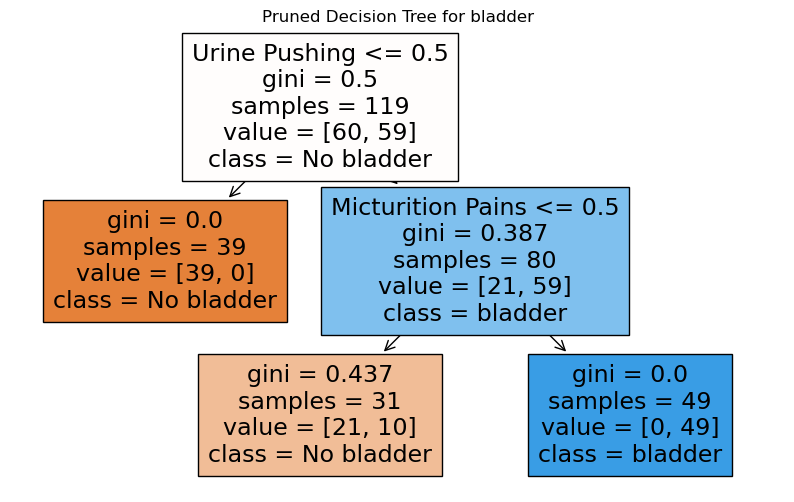

['If Urine Pushing <= 0.50 Then Decision: Bladder False',
 'If Urine Pushing > 0.50 Then Micturition Pains <= 0.50 Then Decision: Bladder False',
 'If Urine Pushing > 0.50 Then Micturition Pains > 0.50 Then Decision: Bladder True']

In [18]:
# choose (0.11385199240986717, 3, 0.8293478260869565) penlize the complex tree while maintain good interbelity
pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0.11385199240986717)
pruned_tree.fit(x_bladder, y_bladder)

plt.figure(figsize=(10, 6))
plot_tree(pruned_tree, feature_names=x_bladder.columns.tolist(), class_names=['No bladder', 'bladder'], filled=True)
plt.title("Pruned Decision Tree for bladder")
plt.show()

pruned_rules = tree_to_rules(pruned_tree, x_bladder.columns.tolist(), 'Bladder')
pruned_rules

In [19]:
# Pruning Multiple Class Tree 
path = tree_combo.cost_complexity_pruning_path(x_combo, y_combo)
ccp_alphas = path.ccp_alphas

# fit trees
trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(x_combo, y_combo)
    trees.append(tree)

num_leaves = []
for tree in trees:
    num_leaves.append(tree.get_n_leaves())

results = list(zip(ccp_alphas,num_leaves))
results

[(0.0, 6),
 (0.04949579831932773, 4),
 (0.08014005602240899, 3),
 (0.10824668850591083, 2),
 (0.20623086722226275, 1)]

In [20]:
# use cv_scores to decide which ccp_alpha to use
cv_scores = []

for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    pruned_tree.fit(x_combo, y_combo)
    scores = cross_val_score(pruned_tree, x_combo, y_combo, cv=5)
    cv_scores.append(scores.mean())
    
results = list(zip(ccp_alphas,num_leaves,cv_scores))
results

[(0.0, 6, 0.95),
 (0.04949579831932773, 4, 0.7391304347826086),
 (0.08014005602240899, 3, 0.7043478260869566),
 (0.10824668850591083, 2, 0.5710144927536233),
 (0.20623086722226275, 1, 0.25833333333333336)]

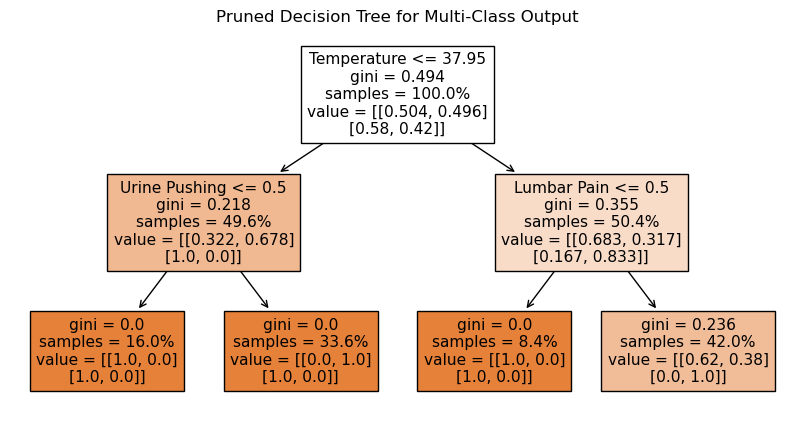

['If Temperature <= 37.95 Then Urine Pushing <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature <= 37.95 Then Urine Pushing > 0.50 Then Decision: Inflammation Bladder: False, Nephritis: True',
 'If Temperature > 37.95 Then Lumbar Pain <= 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False',
 'If Temperature > 37.95 Then Lumbar Pain > 0.50 Then Decision: Inflammation Bladder: True, Nephritis: False']

In [21]:
# choose  (0.04949579831932773, 4, 0.7391304347826086), penlize the complex tree while maintain good interbelity
pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0.04949579831932773)
pruned_tree.fit(x_combo, y_combo)

plt.figure(figsize=(10, 5))
plot_tree(
    pruned_tree, 
    feature_names=x_combo.columns.tolist(), 
    class_names=[
        'F-I, F-N', 
        'T-I, F-N', 
        'F-I, T-N', 
        'T-I, T-N'
    ], 
    filled=True,
    proportion=True 
)
plt.title("Pruned Decision Tree for Multi-Class Output")
plt.show()

rules = tree_to_rules_combo(pruned_tree, x_combo.columns.tolist(), ['Inflammation Bladder', 'Nephritis'])
rules[:]

#### 2 The LASSO and Boosting for Regression
- (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.
- (c) Plot a correlation matrix for the features in the data set.
- (d) Calculate the Coefficient of Variation CV for each feature, where CV = ms , in
which s is sample standard deviation and m is sample mean.
- pcik absolute sqrt(128) features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?
- (f) Fit a linear model using least squares to the training set and report the test error.
- (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.
- (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized4 features. Report the test error for both cases and compare them.
- (i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation. Report the test error obtained.
- (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [23]:
#2a
headers = [
    'state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
    'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
    'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf',
    'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap',
    'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov',
    'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy',
    'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
    'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
    'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent',
    'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8',
    'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup',
    'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous',
    'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
    'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal',
    'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
    'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85',
    'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop',
    'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite',
    'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
    'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
    'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop'
]
df2 = pd.read_csv('../data/communities_data.csv', delimiter=',', decimal='.',header=None )
df2.columns = headers

df2_train = df2[:1495]
df2_test = df2[1495:]

In [24]:
df2.head()

state county community        communityname  fold  population  \
0      8      ?         ?         Lakewoodcity     1        0.19   
1     53      ?         ?          Tukwilacity     1        0.00   
2     24      ?         ?         Aberdeentown     1        0.00   
3     34      5     81440  Willingborotownship     1        0.04   
4     42     95      6096    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06           0.04                  0.9   
1     0.12            0.45          ?              ?                    ?   
2     0.21            0.02          ?              ?                    ?   
3     0.39            0.28          ?              ?                    ?   
4     0.09            0.02          ?              ?                    ?   

   LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                  0.5                 0.32             0.14   
1                    ?                 0.00                ?   
2                    ?                 0.00                ?   
3                    ?                 0.00                ?   
4                    ?                 0.00                ?   

   ViolentCrimesPerPop  
0                 0.20  
1                 0.67  
2                 0.43  
3                 0.12  
4                 0.03  

[5 rows x 128 columns]

In [25]:
#2b. 
non_predictive_columns = ['state', 'county', 'community', 'communityname', 'fold']
df2 = df2.drop(columns=non_predictive_columns)
df2_train = df2[:1495]
df2_test = df2[1495:]

In [26]:

df2_train.describe(), df2_test.describe()

(        population  householdsize  racepctblack  racePctWhite  racePctAsian  \
 count  1495.000000    1495.000000   1495.000000   1495.000000   1495.000000   
 mean      0.058167       0.461732      0.179839      0.752829      0.153712   
 std       0.130359       0.164284      0.256970      0.248594      0.208910   
 min       0.000000       0.000000      0.000000      0.000000      0.000000   
 25%       0.010000       0.350000      0.020000      0.640000      0.040000   
 50%       0.020000       0.430000      0.060000      0.850000      0.070000   
 75%       0.050000       0.540000      0.220000      0.940000      0.170000   
 max       1.000000       1.000000      1.000000      1.000000      1.000000   
 
        racePctHisp  agePct12t21  agePct12t29  agePct16t24   agePct65up  ...  \
 count  1495.000000  1495.000000  1495.000000  1495.000000  1495.000000  ...   
 mean      0.144963     0.422649     0.492087     0.335425     0.428569  ...   
 std       0.233694     0.155993     0

In [27]:
df2_train = df2_train.apply(pd.to_numeric, errors='coerce')
df2_test = df2_test.apply(pd.to_numeric, errors='coerce')

df2_train = df2_train.fillna(df2_train.mean())
df2_test = df2_test.fillna(df2_test.mean())

df2_train_x = df2_train.iloc[:, :122] 
df2_train_y = df2_train.iloc[:, 122:] 
df2_test_x = df2_test.iloc[:, :122] 
df2_test_y = df2_test.iloc[:, 122:] 

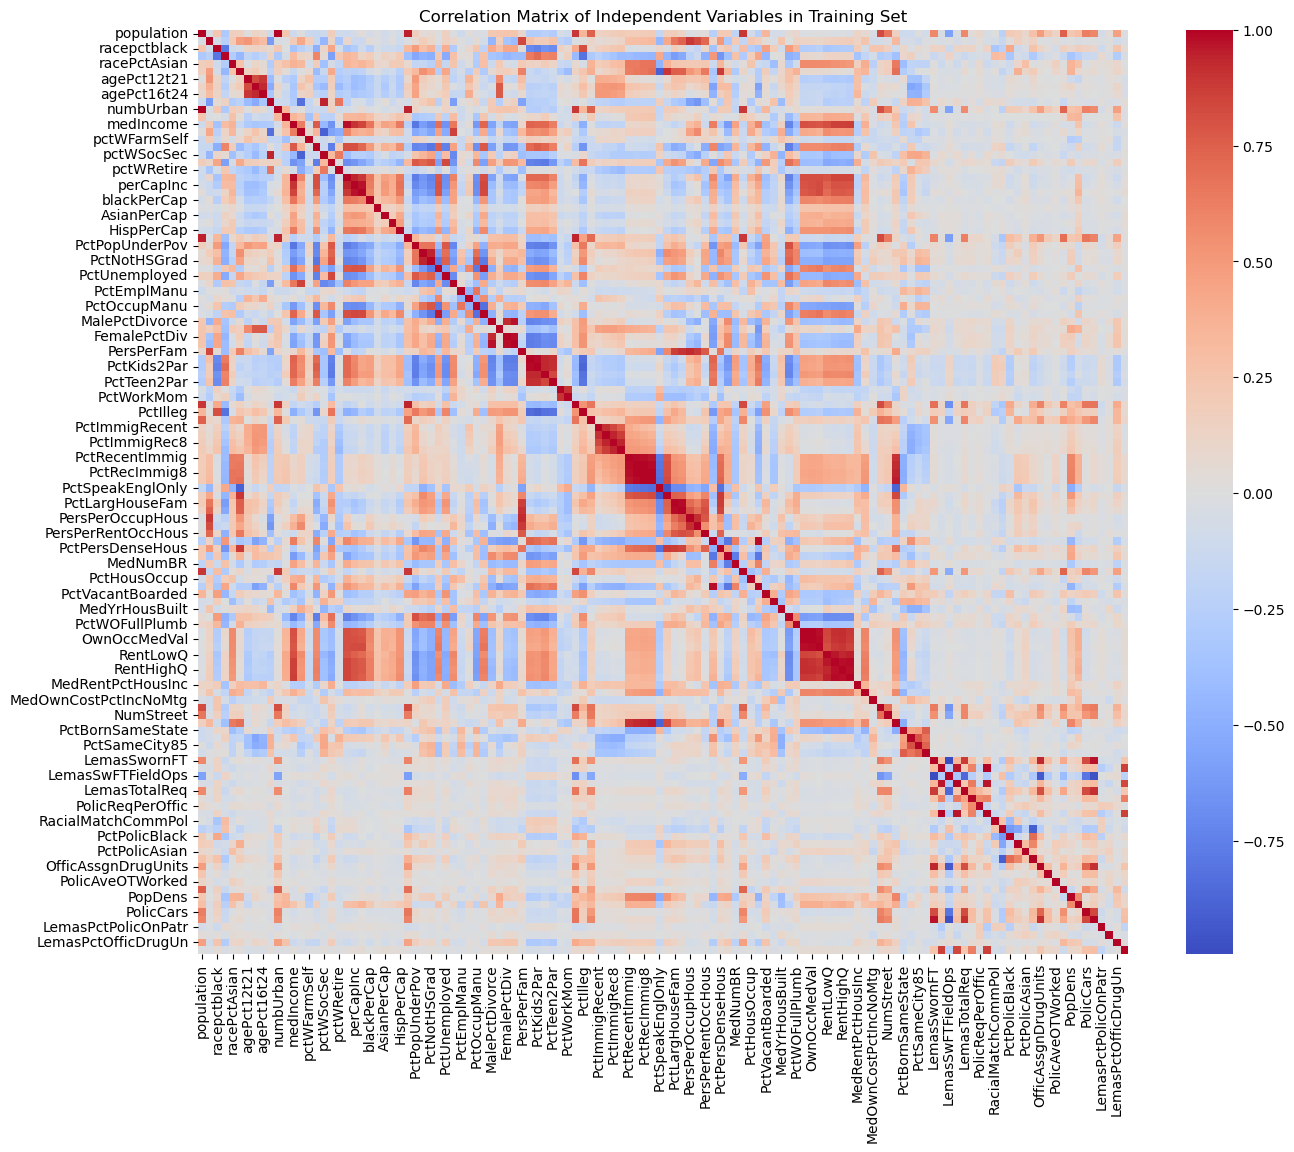

In [28]:
#2c
correlation_matrix_train_x = df2_train_x.corr()

# plot
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_train_x, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Independent Variables in Training Set")
plt.show()

In [29]:
#2d train
means_train = df2_train.mean()
std_devs_train = df2_train.std()

#cv
cv_values_train = std_devs_train / means_train
cv_values_train = cv_values_train.sort_values(ascending=False)[:11]
cv_values_train

NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
NumUnderPov            2.342443
population             2.241105
numbUrban              2.038461
HousVacant             1.968467
LandArea               1.645408
racePctHisp            1.612091
dtype: float64

In [30]:
#2d test 
means_test = df2_test.mean()
std_devs_test = df2_test.std()

#cv
cv_values_test = std_devs_test / means_test
cv_values_test = cv_values_test.sort_values(ascending=False)[:11]
cv_values_test

NumStreet              4.761102
NumInShelters          3.533439
NumImmig               2.803986
NumIlleg               2.729758
LemasPctOfficDrugUn    2.563248
NumUnderPov            2.153037
population             2.077145
HousVacant             1.932141
numbUrban              1.879227
LandArea               1.758711
racePctHisp            1.622216
dtype: float64

In [31]:
#2d entire dataset 
df2_clean = df2.apply(pd.to_numeric, errors='coerce')
df2_clean = df2_clean.fillna(df2_train.mean())

means = df2_clean.mean()
std_devs = df2_clean.std()

#cv
cv_values = std_devs / means
cv_values = cv_values.sort_values(ascending=False)[:11]
cv_values

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
HousVacant             1.958780
LandArea               1.678031
racePctHisp            1.614278
dtype: float64

In [32]:
# through above three group we picked most common element with high cv 
all_values = (
    list(cv_values.keys()) +
    list(cv_values_test.keys()) +
    list(cv_values_train.keys())
)
most_common_11 = Counter(all_values).most_common(11)
keys_only = [item[0] for item in most_common_11]
#add in response variable
keys_only.append('ViolentCrimesPerPop')
keys_only

['NumStreet',
 'NumInShelters',
 'NumIlleg',
 'NumImmig',
 'LemasPctOfficDrugUn',
 'NumUnderPov',
 'population',
 'numbUrban',
 'HousVacant',
 'LandArea',
 'racePctHisp',
 'ViolentCrimesPerPop']

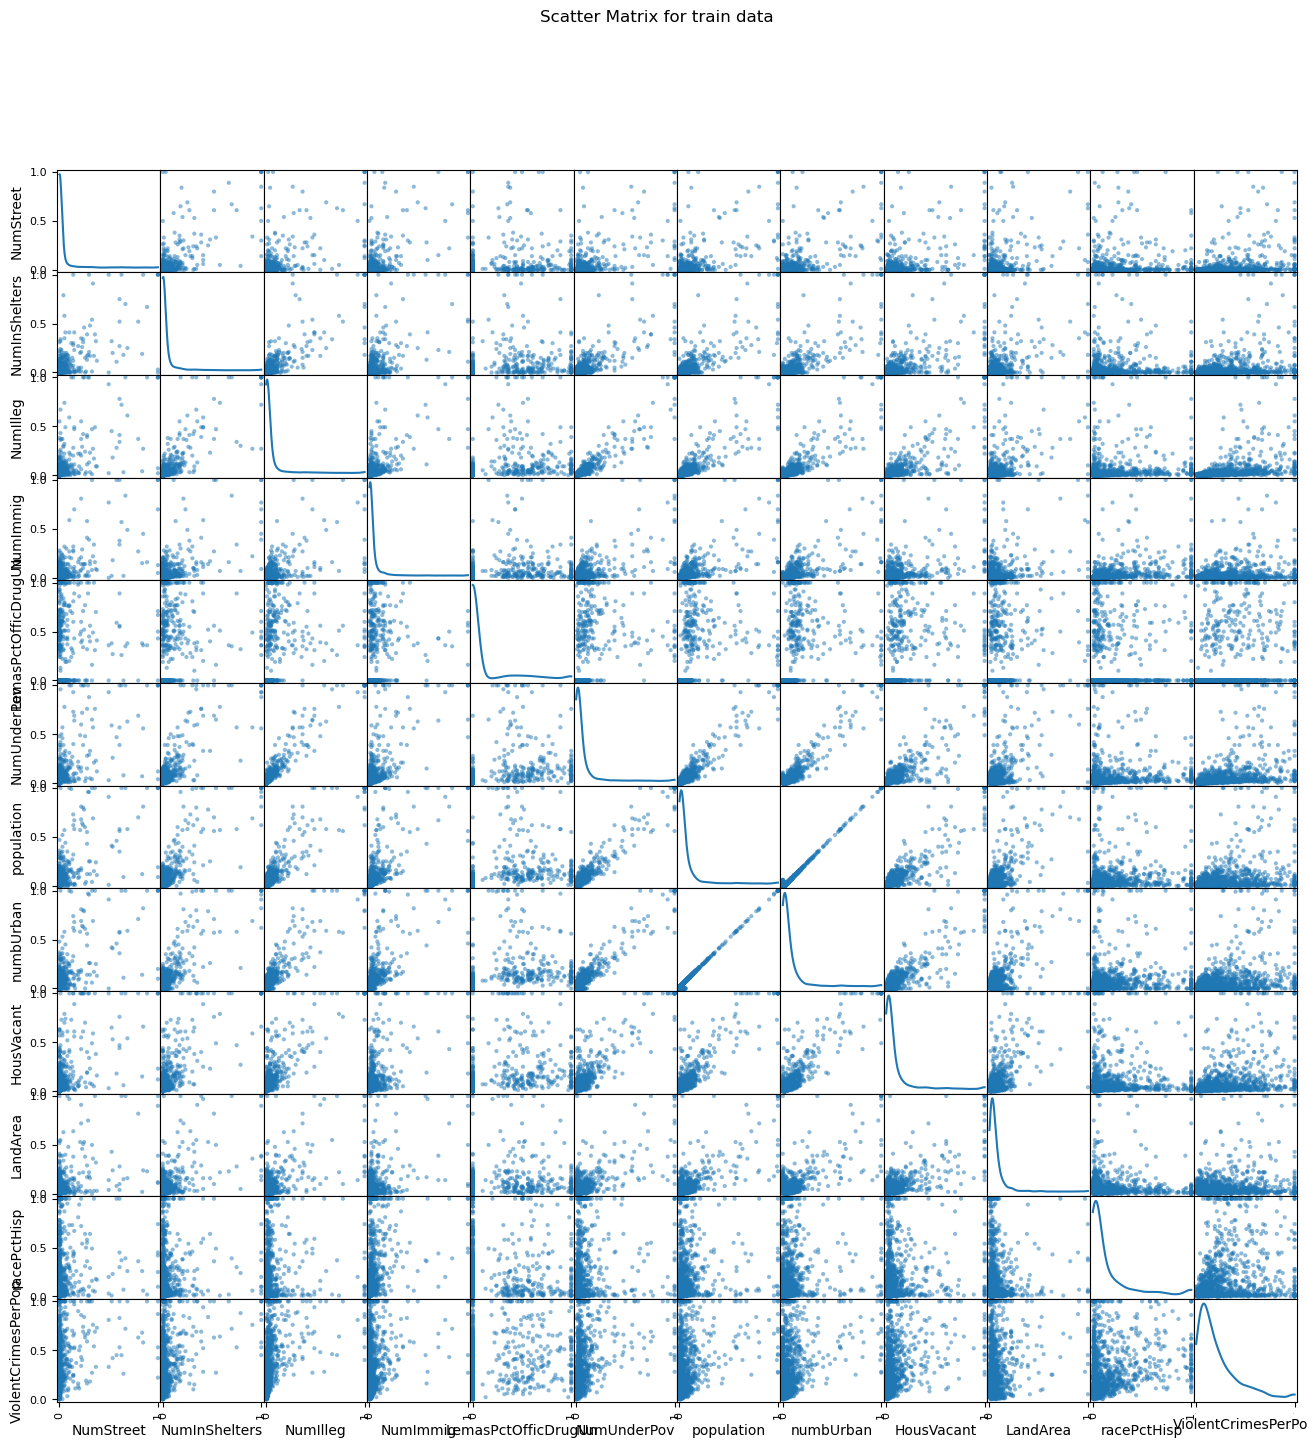

In [33]:
#train data scatter and box plot 
df2_train_common11 = df2_train[keys_only]

pd.plotting.scatter_matrix(df2_train_common11, figsize=(16, 16), alpha=0.5, diagonal='kde')
plt.suptitle("Scatter Matrix for train data")
plt.xticks(fontsize=1)
plt.yticks(fontsize=1)
plt.show()

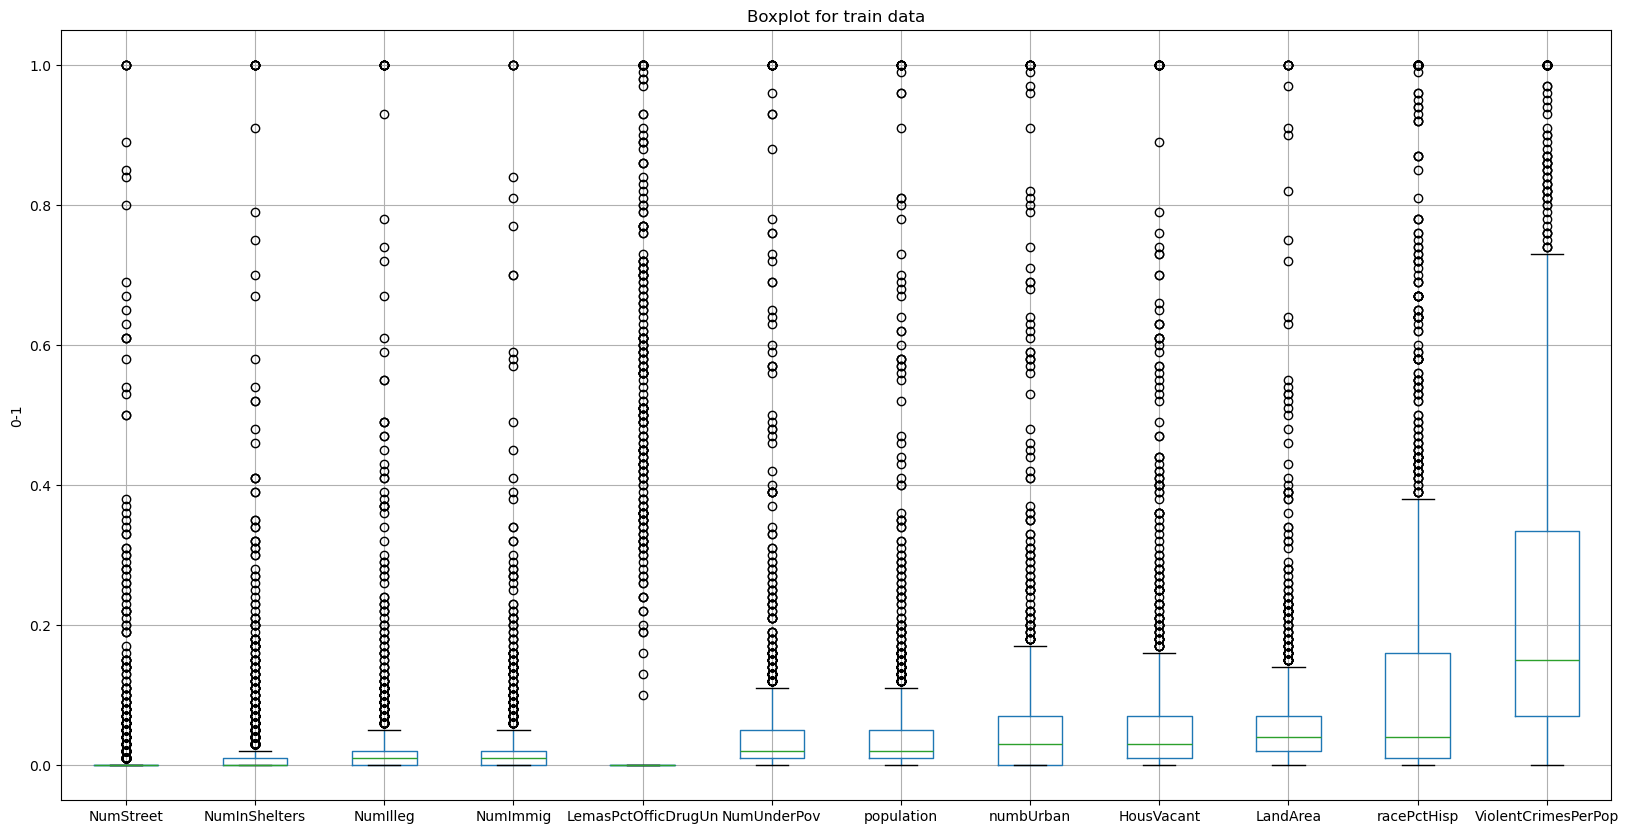

In [34]:
# boxplot for train data 
plt.figure(figsize=(20, 10))
df2_train_common11.boxplot()
plt.title("Boxplot for train data")
plt.ylabel("0-1")
plt.show()

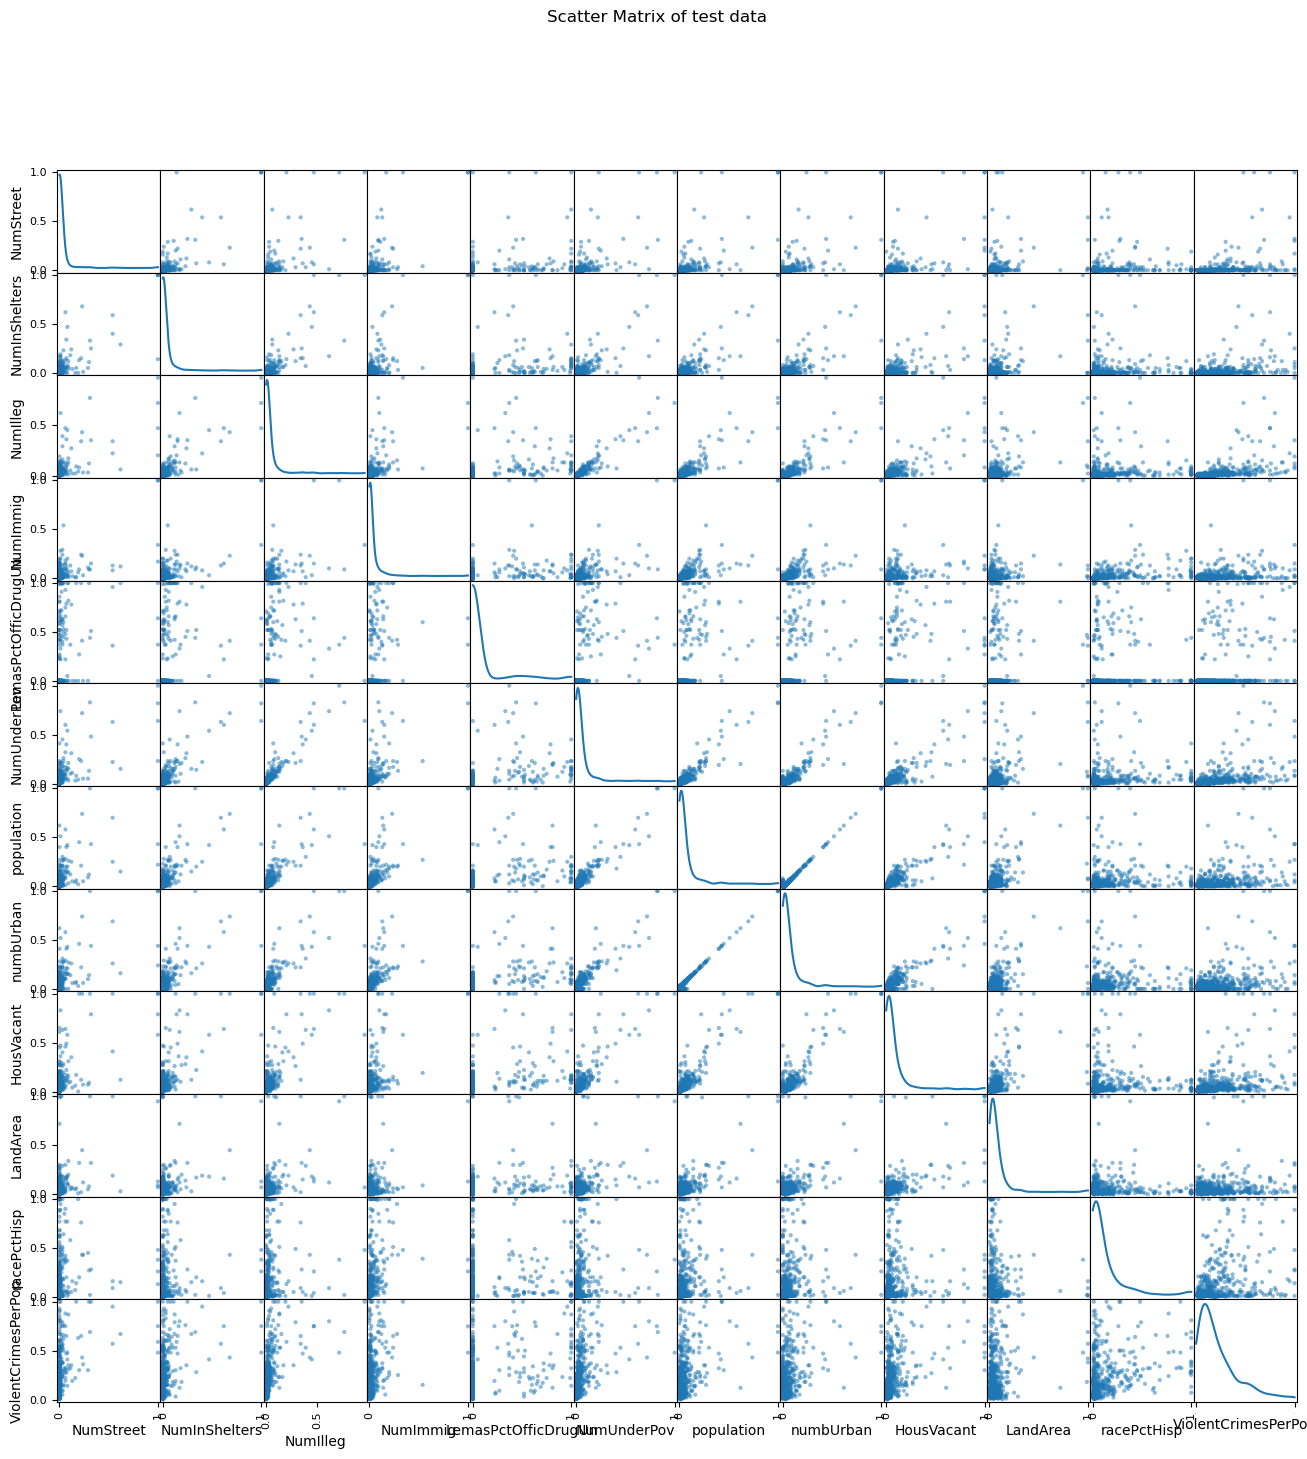

In [35]:
#test data scatter and box plot 
df2_test_common11 = df2_test[keys_only]

pd.plotting.scatter_matrix(df2_test_common11, figsize=(16, 16), alpha=0.5, diagonal='kde')
plt.suptitle("Scatter Matrix of test data")
plt.xticks(fontsize=1)
plt.yticks(fontsize=1)
plt.show()

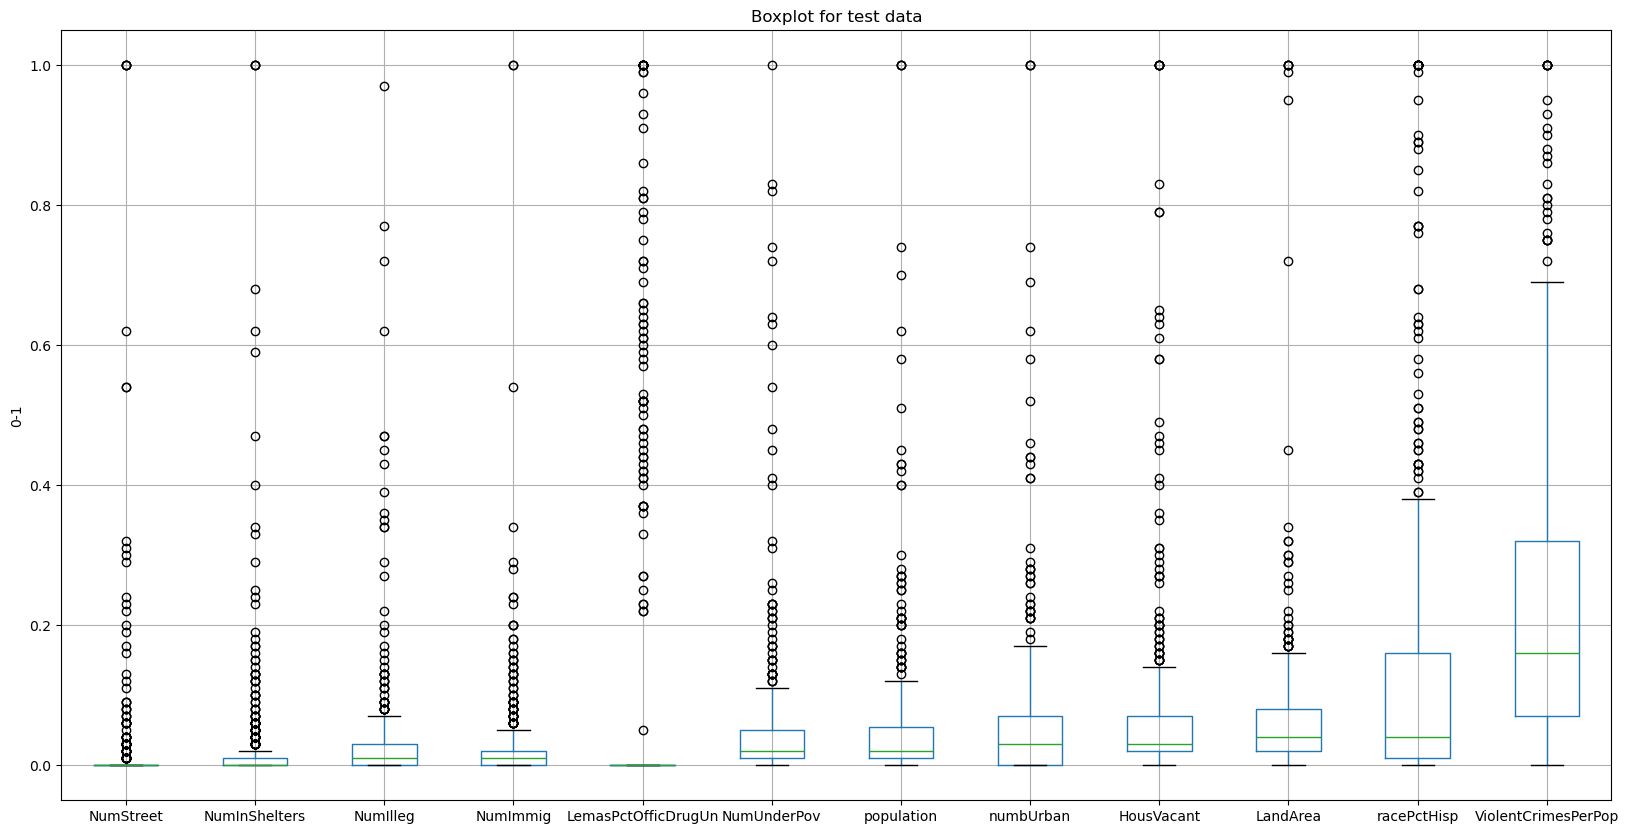

In [36]:
# boxplot for test data 
plt.figure(figsize=(20, 10))
df2_test_common11.boxplot()
plt.title("Boxplot for test data")
plt.ylabel("0-1")
plt.show()

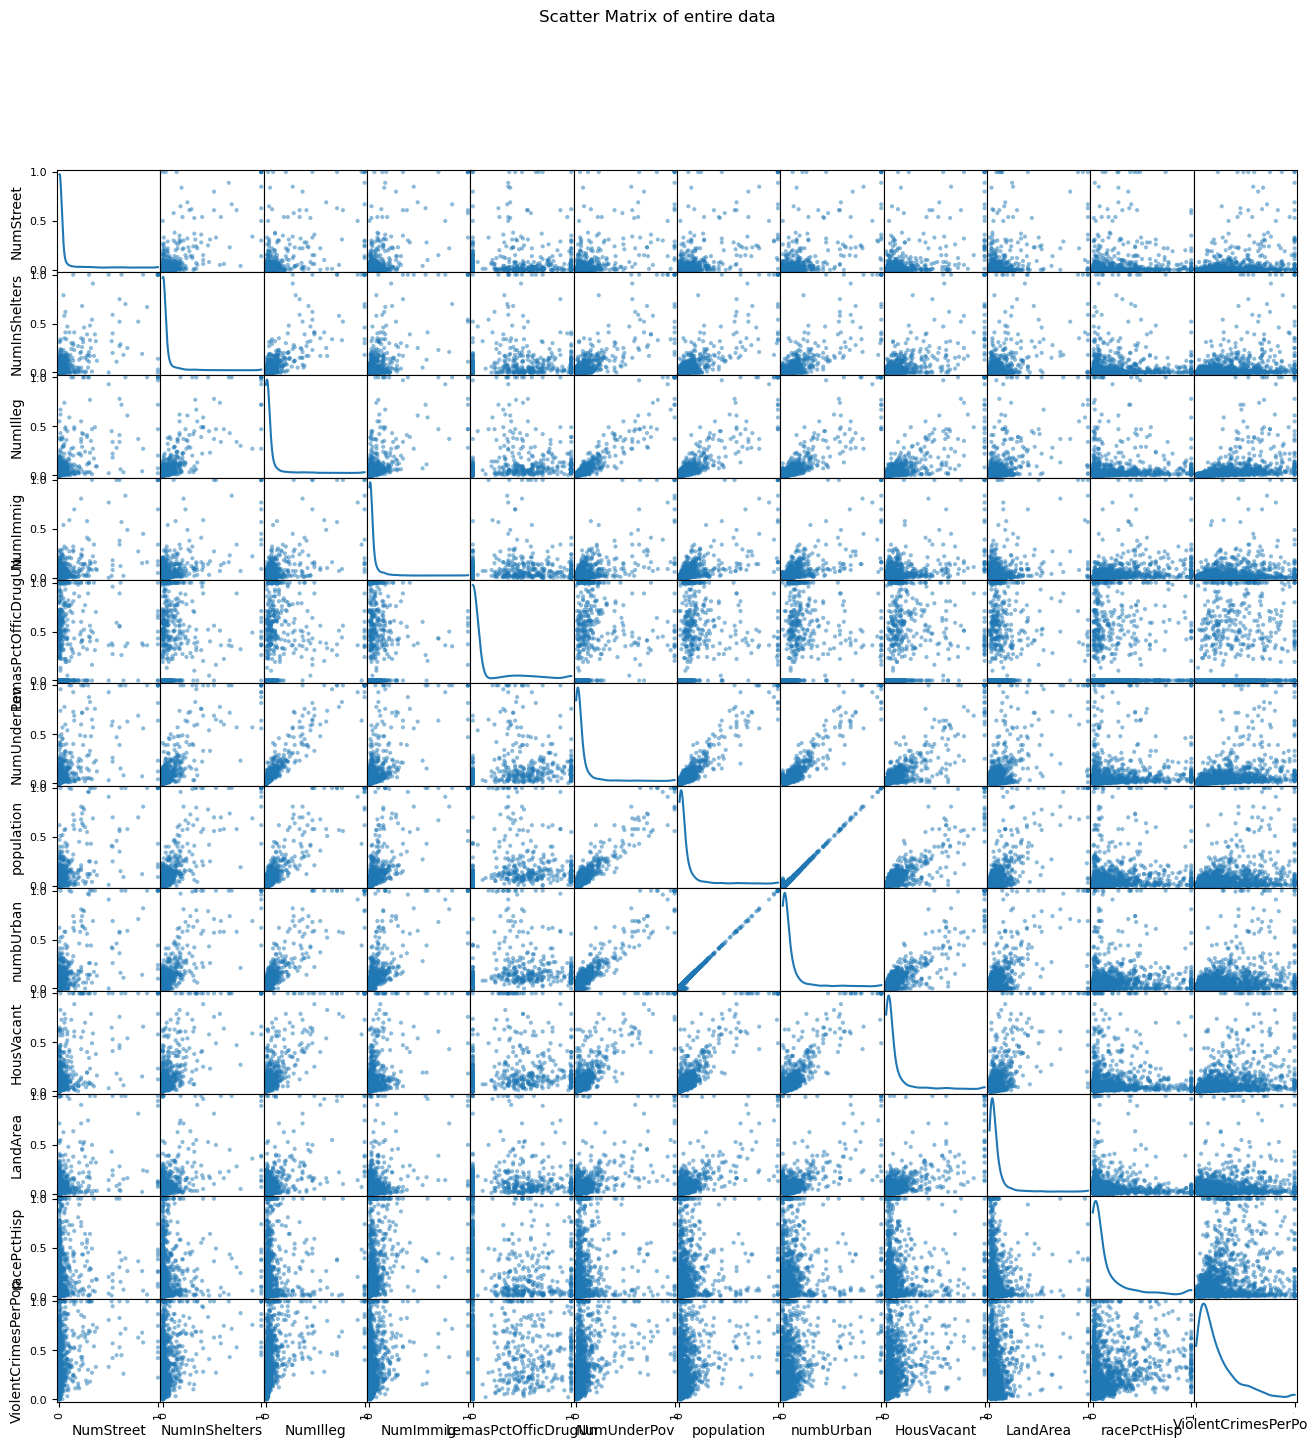

In [37]:
#entire data scatter and box plot 
df2_clean_common11 = df2_clean[keys_only]

pd.plotting.scatter_matrix(df2_clean_common11, figsize=(16, 16), alpha=0.5, diagonal='kde')
plt.suptitle("Scatter Matrix of entire data")
plt.xticks(fontsize=1)
plt.yticks(fontsize=1)

plt.show()

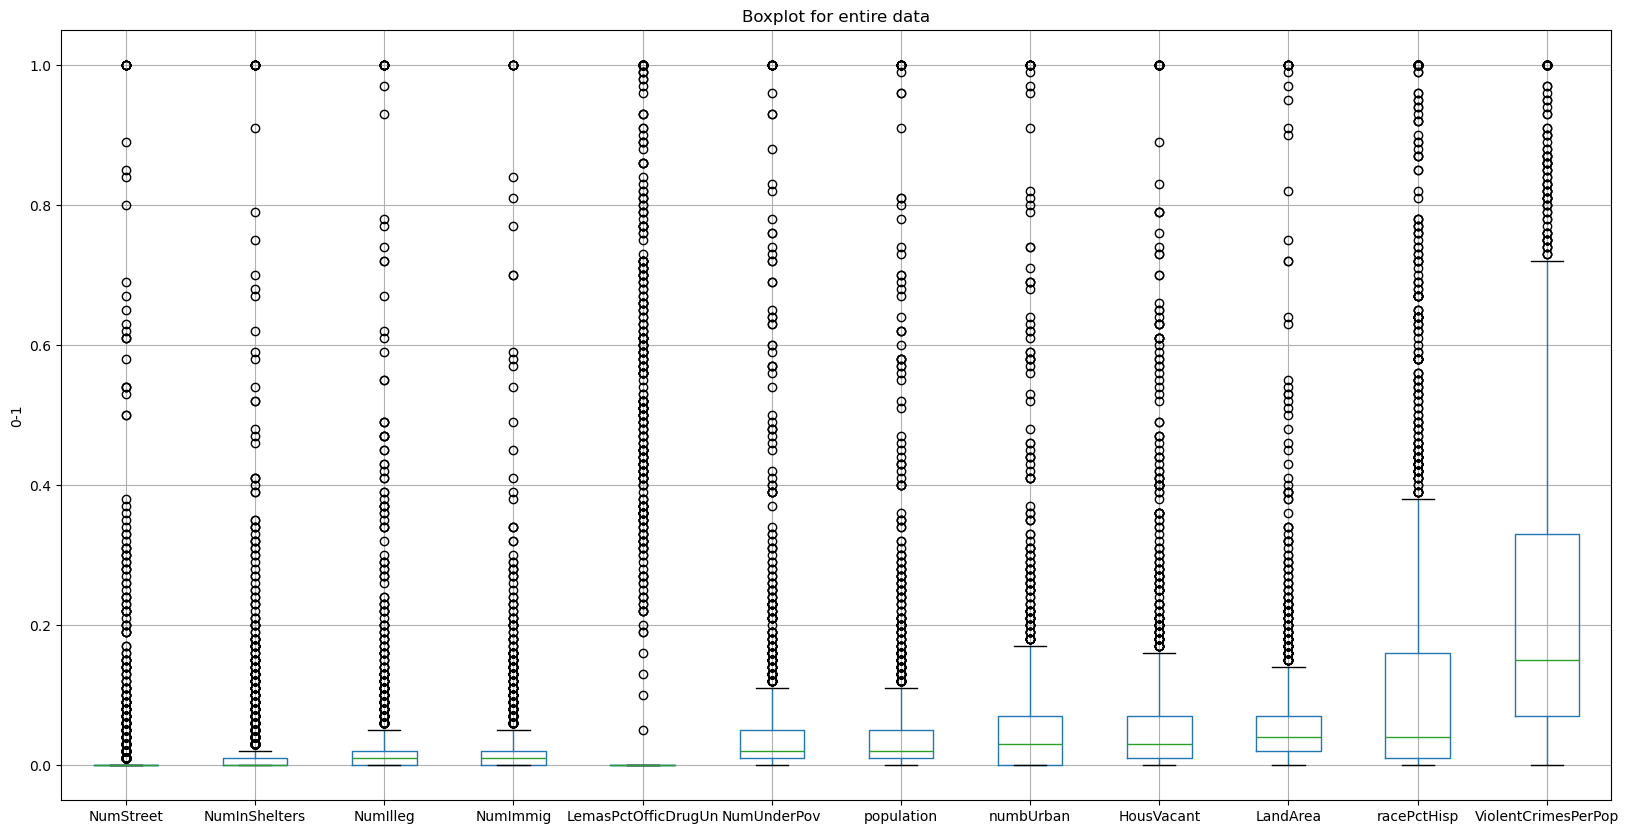

In [38]:
# boxplot for entire data 
plt.figure(figsize=(20, 10))
df2_clean_common11.boxplot()
plt.title("Boxplot for entire data")
plt.ylabel("0-1")
plt.show()

##### 2e Answer; by looking at the scatter plot, it is hard to find relationship between independent variables and response variable. However, we can see that some dependent variable are correlated. 

In [40]:
#2(f) Fit a linear model using least squares to the training set and report the test error.
linear_model = LinearRegression()
linear_model.fit(df2_train_x, df2_train_y)

y_test_pred = linear_model.predict(df2_test_x)

# mse(test)
test_error = mean_squared_error(df2_test_y, y_test_pred)
test_error

0.018112462026533487

In [41]:
# Standardaized 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(df2_train_x)
x_test_scaled = scaler.transform(df2_test_x)

# run ridge  
ridge_model = RidgeCV(store_cv_values=True)
ridge_model.fit(x_train_scaled, df2_train_y)  # Fit on scaled training data

y_test_pred_ridge = ridge_model.predict(x_test_scaled)

# test(MSE)
ridge_test_error = mean_squared_error(df2_test_y, y_test_pred_ridge)
best_alpha = ridge_model.alpha_

ridge_test_error, best_alpha

(0.0178045844235366, 10.0)

In [42]:
#2h Lasso unstandardized
lasso_model = LassoCV(cv=5, random_state=0)
lasso_model.fit(df2_train_x, df2_train_y.values.ravel())  # Flatten y for compatibility
y_test_pred_lasso = lasso_model.predict(df2_test_x)
lasso_test_error_unstandardized = mean_squared_error(df2_test_y, y_test_pred_lasso)

# selected feature on unstandardzied
selected_features_unstandardized = df2_train_x.columns[lasso_model.coef_ != 0].tolist()

# standardize 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(df2_train_x)
x_test_scaled = scaler.transform(df2_test_x)

# Lasso standardized
lasso_model_standardized = LassoCV(cv=5, random_state=0)
lasso_model_standardized.fit(x_train_scaled, df2_train_y.values.ravel())

# MSE(test)
y_test_pred_lasso_standardized = lasso_model_standardized.predict(x_test_scaled)
lasso_test_error_standardized = mean_squared_error(df2_test_y, y_test_pred_lasso_standardized)

# selected feature on standardzied
selected_features_standardized = df2_train_x.columns[lasso_model_standardized.coef_ != 0].tolist()

lasso_test_error_unstandardized, selected_features_unstandardized, lasso_test_error_standardized, selected_features_standardized


/Users/main/anaconda3/envs/autogluon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00975293022717949, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
/Users/main/anaconda3/envs/autogluon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010113610150753516, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
/Users/main/anaconda3/envs/autogluon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009826702370876461, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
/User

(0.017735383043771754,
 ['racepctblack',
  'racePctAsian',
  'agePct12t21',
  'agePct12t29',
  'pctUrban',
  'pctWWage',
  'pctWFarmSelf',
  'pctWInvInc',
  'pctWSocSec',
  'pctWPubAsst',
  'pctWRetire',
  'whitePerCap',
  'blackPerCap',
  'indianPerCap',
  'AsianPerCap',
  'OtherPerCap',
  'HispPerCap',
  'PctPopUnderPov',
  'PctLess9thGrade',
  'PctEmploy',
  'PctEmplManu',
  'PctOccupManu',
  'MalePctDivorce',
  'MalePctNevMarr',
  'FemalePctDiv',
  'PctKids2Par',
  'PctYoungKids2Par',
  'PctTeen2Par',
  'PctWorkMom',
  'NumIlleg',
  'PctIlleg',
  'NumImmig',
  'PctImmigRec10',
  'PctRecImmig10',
  'PctNotSpeakEnglWell',
  'PctLargHouseOccup',
  'PersPerOccupHous',
  'PctPersOwnOccup',
  'PctPersDenseHous',
  'PctHousLess3BR',
  'MedNumBR',
  'HousVacant',
  'PctHousOccup',
  'PctVacantBoarded',
  'PctVacMore6Mos',
  'MedYrHousBuilt',
  'PctHousNoPhone',
  'PctWOFullPlumb',
  'OwnOccLowQuart',
  'RentLowQ',
  'MedRent',
  'MedRentPctHousInc',
  'MedOwnCostPctInc',
  'MedOwnCostPctIn

In [43]:
#2i. Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation. Report the test error obtained.
cv_errors = []
# set m to limit 20
for m in range(1, 20 + 1):
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(df2_train_x)
    
    # fit linear regress
    model = LinearRegression()
    cv_score = cross_val_score(model, X_train_pca, df2_train_y.values.ravel(), cv=5, scoring='neg_mean_squared_error')
    cv_errors.append(-cv_score.mean())

# Find optimal m
optimal_m = np.argmin(cv_errors) + 1 
pca_final = PCA(n_components=optimal_m)
x_train_pca_final = pca_final.fit_transform(df2_train_x)
x_test_pca_final = pca_final.transform(df2_test_x)

# using best m on linear regression and predict 
final_model = LinearRegression()
final_model.fit(x_train_pca_final, df2_train_y)
y_test_pred_pcr = final_model.predict(x_test_pca_final)

# MSE(test)
pcr_test_error = mean_squared_error(df2_test_y, y_test_pred_pcr)

optimal_m, pcr_test_error


(13, 0.01784649117726956)

In [44]:
#2(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.
# set parameters for XGBoost
initial_params = {'subsample': 0.8, 'colsample_bytree': 0.8,'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 4}

# set alpha pramater 
param_grid = {'reg_alpha': [0.1, 1, 10, 50, 100] }

# run xgboost and find best alpha using cross validation
xgb_model = xgb.XGBRegressor(**initial_params, objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df2_train_x, df2_train_y.values.ravel())

# Best model and alpha parameter
best_alpha = grid_search.best_params_['reg_alpha']
best_model = grid_search.best_estimator_

# calculate test(mse)
y_test_pred = best_model.predict(df2_test_x)
test_error = mean_squared_error(df2_test_y, y_test_pred)

best_alpha, test_error

(1, 0.016108157600319917)